In [1]:
import timm
from torchsummary import summary
import torch
from torch import nn
import torch.nn.functional as F
from importlib import reload
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import albumentations
from albumentations import augmentations
import albumentations.pytorch
from albumentations.pytorch.functional import img_to_tensor
from tqdm import tqdm
from tqdm import tqdm_notebook
from torch.utils.data import DataLoader
from prettytable import PrettyTable
import prettytable

In [2]:
import PIL
from PIL import Image
from PIL import Image, ImageChops, ImageEnhance
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from itertools import chain

In [4]:
def ELA(img_path, ROOT):
    """Performs Error Level Analysis over a directory of images"""

    TEMP = os.path.join(ROOT, img_path[:-4]+'ela_' + 'temp.jpg')
    SCALE = 20
    original = Image.open(os.path.join(ROOT, img_path))
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
    except:
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
    
    os.remove(TEMP)   
    d = diff.load()
    
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])
    diff = diff.resize((419,402), resample=cv2.INTER_AREA)
    return np.array(diff)

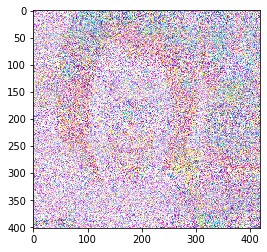

In [5]:
ela = ELA('noisy.png', '')
plt.imshow(ela)
plt.show()
# plt.imsave('elaxx.png',ela)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


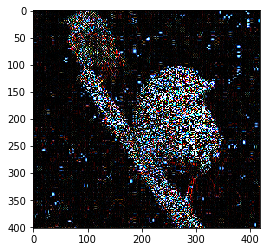

In [46]:
normalize={"mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
            "std" : [0.2744059987371694, 0.2684138285232067, 0.29527622263685294]}

from segmentation.srm_kernel import setup_srm_layer
srm_conv = setup_srm_layer()
img = cv2.imread('noisy.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(419, 402), cv2.INTER_CUBIC)

image = img_to_tensor(img, normalize).unsqueeze(0)

res = srm_conv(image)
res = res.squeeze().permute(1,2,0).numpy()
plt.figure()
plt.imshow(res)
plt.show()
# plt.imsave('srm.png',(res).astype('uint8'))

In [5]:
df = pd.read_csv(f"G:\IMANIP Datasets\CoMoFoD\comofod.csv").reset_index(drop=True)
# rows = df[df["fold"] == 9]
rows = df

real = rows[rows["label"] == 0].sample(n=10)
fakes = rows[rows["label"] == 1].sample(n=10)

data = pd.concat([fakes, real])
data = data.values

In [6]:
normalize = {
    "mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
    "std": [0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
}
valid_aug = albumentations.Compose(
    [
        augmentations.transforms.Resize(224, 224, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.ToTensor()
    ],
    additional_targets={'ela':'image'}
)

In [7]:
def patch_func(img, ela, mask, patch_size):
    d = img.shape
    patches = []
    coords = []
    for i in range(0, d[0], patch_size):
        for j in range(0, d[1], patch_size):
            x = i + patch_size
            y = j + patch_size
            if x > d[0] or y > d[1]:
                break
            temp_img = img[i: x, j: y]
            temp_ela = ela[i: x, j: y]
            temp_mask = mask[i: x, j: y]
            patches.append((temp_img, temp_mask, temp_ela))
            coords.append((i, j))
    return patches, coords

In [7]:
image = cv2.imread('noisy.png', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA)

patches, coords = patch_func(image, image, image, 128)

In [8]:
from segmentation.merged_net import SRM_Classifer
from segmentation.smp_srm import SMP_SRM

classifier = SRM_Classifer().to('cuda')
classifier = nn.DataParallel(classifier)
classifier.eval();

localizer = SMP_SRM().to('cuda')
localizer = nn.DataParallel(localizer)
localizer.eval();

In [41]:
data = [['probe/NC2016_7420.jpg',1,'reference/manipulation/mask/NC2016_9704.png']]

G:/IMANIP Datasets/NC2016_Test0613\probe/NC2016_7420.jpg


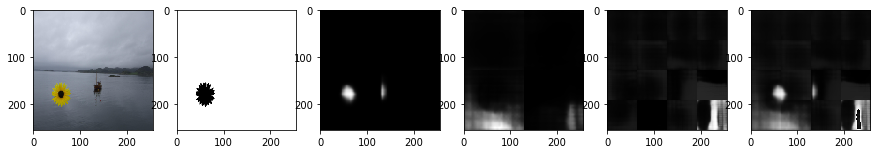

 +-----------+  +-----------------------+  +-----------------------------------------------+ 
 |  256x256  |  |        128x128        |  |                     64x64                     | 
 +-----------+  +-----------+-----------+  +-----------+-----------+-----------+-----------+ 
 | pred:0.59 |  | pred:0.18 | pred:0.16 |  | pred:0.13 | pred:0.10 | pred:0.11 | pred:0.10 | 
 | dice:0.01 |  | dice:0.14 | dice:0.05 |  | dice:0.36 | dice:0.39 | dice:0.45 | dice:0.51 | 
 |  iou:0.00 |  |  iou:0.08 |  iou:0.03 |  |  iou:0.22 |  iou:0.24 |  iou:0.29 |  iou:0.35 | 
 +-----------+  +-----------+-----------+  +-----------+-----------+-----------+-----------+ 
                | pred:0.93 | pred:0.36 |  | pred:0.10 | pred:0.10 | pred:0.10 | pred:0.10 | 
                | dice:0.26 | dice:0.14 |  | dice:0.55 | dice:0.58 | dice:0.52 | dice:0.56 | 
                |  iou:0.15 |  iou:0.07 |  |  iou:0.38 |  iou:0.41 |  iou:0.35 |  iou:0.39 | 
                +-----------+-----------+  +-----------+----

In [42]:
from pytorch_toolbelt import losses
from utils import *
import seg_metrics

root_dir = 'G:/IMANIP Datasets/NC2016_Test0613'
for row in data[:1]:
    image_name, label, mask = row

    image_path = os.path.join(root_dir, image_name)
    print(image_path)

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA)

    ela_image = ELA(image_path, root_dir)
    
    if not isinstance(mask, str) and np.isnan(mask):
        mask_image = np.zeros((image.shape[0], image.shape[1]))
    else:
        mask_path = os.path.join(root_dir, mask)
        mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_image = cv2.resize(mask_image, (256,256), interpolation=cv2.INTER_AREA)

    # dice_tot = AverageMeter()
    # jaccard_tot = AverageMeter()
    # preds = []
    # targets = []
    # labels = []
    with torch.no_grad():
        plt.figure(1, figsize=(15,12))

        plt.subplot(161)
        plt.imshow(image)
        plt.subplot(162)
        plt.imshow(mask_image, cmap='gray')

        # ---------- 256 x 256 -------------
        classifier.load_state_dict(torch.load('best_weights\\CASIA_FULL_ELA.h5'))
        localizer.load_state_dict(torch.load('best_weights\\224CASIA_FULLDeepLabv3+EffNet+SRM_[01_11_19_19_39].h5'))

        trans = valid_aug(image=image, mask=mask_image, ela=ela_image)
        image_tensor = trans["image"].unsqueeze(0).cuda()
        mask_tensor = trans["mask"].unsqueeze(0).cuda()
        ela_tensor = trans["ela"].unsqueeze(0).cuda()

        out_label, _ = classifier(image_tensor, ela_tensor)
        out_label_256 = F.logsigmoid(out_label.cpu().detach()).exp().item()
        out_mask = localizer(image_tensor, ela_tensor)
        out_mask_256 = F.logsigmoid(out_mask.cpu().detach()).exp()

        dice = losses.functional.soft_dice_score(out_mask_256, mask_tensor.cpu().detach())
        jaccard = losses.functional.soft_jaccard_score(out_mask_256, mask_tensor.cpu().detach())
        
        out_mask_256 = image2np(out_mask_256.squeeze(0))
        out_mask_256 = cv2.resize(out_mask_256, (256,256), interpolation=cv2.INTER_AREA)

        plt.imsave('in.png', image)
        plt.imsave('256.png', out_mask_256, cmap='gray')
        plt.subplot(163)
        plt.imshow(out_mask_256, cmap='gray')

        t_256 = PrettyTable(header=False, hrules=prettytable.ALL, title='256x256')
        t_256.add_row([f'pred:{out_label_256:.2f}\ndice:{dice:.2f}\niou:{jaccard:.2f}'])

        # ------------ 128 x 128 ------------------
        classifier.load_state_dict(torch.load('best_weights\\CASIA_128_ELA.h5'))
        localizer.load_state_dict(torch.load('best_weights\\224CASIA_128DeepLabv3+EffNet+SRM_[02_11_01_50_22].h5'))

        patches_128, coords_128 = patch_func(image, ela_image, mask_image, 128)
        out_label_128 = []
        cnt = 1
        t_128 = PrettyTable(header=False, hrules=prettytable.ALL, title='128x128')
        out_mask_128_combined = np.random.randn(256,256)

        for patch, coord in zip(patches_128, coords_128):
            trans = valid_aug(image=patch[0], mask=patch[1], ela=patch[2])
            image_tensor = trans["image"].unsqueeze(0).cuda()
            mask_tensor = trans["mask"].unsqueeze(0).cuda()
            ela_tensor = trans["ela"].unsqueeze(0).cuda()

            out_label, _ = classifier(image_tensor, ela_tensor)
            out_label = F.logsigmoid(out_label.cpu().detach()).exp().item()
            out_mask = localizer(image_tensor, ela_tensor)
            out_mask = F.logsigmoid(out_mask.cpu().detach()).exp()

            dice = losses.functional.soft_dice_score(out_mask, mask_tensor.cpu().detach())
            jaccard = losses.functional.soft_jaccard_score(out_mask, mask_tensor.cpu().detach())
            
            out_label_128.append(f'pred:{out_label:.2f}\ndice:{dice:.2f}\niou:{jaccard:.2f}')
            if cnt%2 == 0:
                t_128.add_row(out_label_128)
                out_label_128 = list()
            cnt += 1

            out_mask = image2np(out_mask.squeeze(0))
            out_mask = cv2.resize(out_mask, (128,128), interpolation=cv2.INTER_AREA)
            out_mask *= out_label
            # out_mask = out_mask > 0.75
            for rows in range(out_mask.shape[0]):
                for cols in range(out_mask.shape[1]):
                    x = coord[0] + rows
                    y = coord[1] + cols
                    out_mask_128_combined[x][y] = out_mask[rows][cols]
            plt.subplot(164)
            plt.imshow(out_mask_128_combined, cmap='gray')
            plt.imsave('128.png', out_mask_128_combined, cmap='gray')
            # plt.figure()
            # plt.subplot(121)
            # plt.imshow(image2np(mask_tensor.squeeze(0)))
            # plt.subplot(122)
            # plt.imshow(out_mask)
            # plt.show()

        # ------------ 64 x 64 ------------------
        classifier.load_state_dict(torch.load('best_weights\\CASIA_64_ELA.h5'))
        localizer.load_state_dict(torch.load('best_weights\\224CASIA_64DeepLabv3+EffNet+SRM_[01_11_03_13_15].h5'))

        patches_64, coords_64 = patch_func(image, ela_image, mask_image, 64)
        out_label_64 = []
        cnt = 1
        t_64 = PrettyTable(header=False, hrules=prettytable.ALL, title='64x64')
        out_mask_64_combined = np.random.randn(256,256)

        for patch, coord in zip(patches_64, coords_64):
            trans = valid_aug(image=patch[0], mask=patch[1], ela=patch[2])
            image_tensor = trans["image"].unsqueeze(0).cuda()
            mask_tensor = trans["mask"].unsqueeze(0).cuda()
            ela_tensor = trans["ela"].unsqueeze(0).cuda()

            out_label, _ = classifier(image_tensor, ela_tensor)
            out_label = F.logsigmoid(out_label.cpu().detach()).exp().item()
            out_mask = localizer(image_tensor, ela_tensor)
            out_mask = F.logsigmoid(out_mask.cpu().detach()).exp()

            dice = losses.functional.soft_dice_score(out_mask, mask_tensor.cpu().detach())
            jaccard = losses.functional.soft_jaccard_score(out_mask, mask_tensor.cpu().detach())
            
            out_label_64.append(f'pred:{out_label:.2f}\ndice:{dice:.2f}\niou:{jaccard:.2f}')
            if cnt%4 == 0:
                t_64.add_row(out_label_64)
                out_label_64 = list()
            cnt += 1

            out_mask = image2np(out_mask.squeeze(0))
            out_mask = cv2.resize(out_mask, (64,64), interpolation=cv2.INTER_AREA)
            out_mask *= out_label
            # out_mask = out_mask > 0.70
            for rows in range(out_mask.shape[0]):
                for cols in range(out_mask.shape[1]):
                    x = coord[0] + rows
                    y = coord[1] + cols 
                    out_mask_64_combined[x][y] = out_mask[rows][cols]
            plt.subplot(165)
            plt.imshow(out_mask_64_combined, cmap='gray')
            plt.imsave('64.png', out_mask_64_combined, cmap='gray')

            # plt.figure()
            # plt.subplot(121)
            # plt.imshow(image2np(mask_tensor.squeeze(0)))
            # plt.subplot(122)
            # plt.imshow(out_mask)
            # plt.show()
    out_comb = out_mask_256 + out_mask_128_combined + out_mask_64_combined
    out_comb = np.array(out_comb * 255, dtype = np.uint8)
    plt.subplot(166)
    plt.imshow(out_comb, cmap='gray')   

    plt.show()
    t = PrettyTable(header=False, border=False)
    t.add_row([t_256.get_string(),t_128.get_string(),t_64.get_string()])
    print(t)
    # print(t_256.get_string()+" "+t_128.get_string()+" "+ t_64.get_string())
#     loss = losses.DiceLoss(mode='binary', log_loss=False, from_logits=False)
#     dice_loss = loss(out_mask, mask_tensor)
#     print(f"Dice Loss:{dice_loss}")
#     print(f"Dice:{dice}, IOU:{jaccard}, Label:{out_label}")
#     plt.figure(1)
#     plt.subplot(131)
#     plt.imshow(image)

#     plt.subplot(132)
#     plt.imshow(mask_image)

#     plt.subplot(133)
#     plt.imshow(image2np(out_mask.squeeze(0)))
#     plt.show()

# print(f"Total Dice:{dice_tot.avg}, Total IOU:{jaccard_tot.avg}")
# dice_tot2, best_dice = seg_metrics.dice_coeff(preds, targets)  
# jaccard_tot2, best_iou = seg_metrics.jaccard_coeff(preds, targets) 
# print(f"Total Dice2:{dice_tot2.item()}, Total IOU2:{jaccard_tot2.item()}")